# Hybrid Monte Carlo Approach

## Import Required Libraries

In [1]:
import numpy as np  # Numerical computations and array operations  
import matplotlib.pyplot as plt  # Plotting and visualization  
import pandas as pd  # Data handling and manipulation  
import re  # Regular expressions for text processing  
from sklearn.utils import resample  # Bootstrap resampling utility from scikit-learn  

## Define all functions

In [2]:
#--------------------------------------------------------------------
# Functions for the HMC simulation
#--------------------------------------------------------------------

# Build the fermion matrix M(phi)
def build_M(phi):
    """
    Constructs the fermion matrix M for a given field configuration phi.
    """
    Nt = len(phi)  # Number of time slices
    M = np.eye(Nt)  # Start with identity matrix
    for t in range(Nt - 1):
        M[t + 1, t] = -np.exp(phi[t])  # Fill lower diagonal elements
    M[0, Nt - 1] = np.exp(phi[Nt - 1])  # Apply anti-periodic boundary condition
    return M

# Compute the gradient of the action S[ϕ]
def dS_dphi(phi, Utilde, Nt):
    """
    Computes the gradient of the action S with respect to the field phi.
    """
    grad_quad = phi / Utilde  # Quadratic part of gradient
    
    M_phi = build_M(phi)
    M_minus_phi = build_M(-phi)
    
    inv_M_phi = np.linalg.inv(M_phi)  # Compute inverse of M(phi)
    inv_M_minus_phi = np.linalg.inv(M_minus_phi)  # Compute inverse of M(-phi)
    
    grad_det = np.zeros_like(phi)
    for t in range(Nt):
        dM_dphi_t = np.zeros((Nt, Nt))  # Derivative matrix
        if t < Nt - 1:
            dM_dphi_t[t + 1, t] = -np.exp(phi[t])
        else:
            dM_dphi_t[0, t] = np.exp(phi[t])
        
        dM_minus_dphi_t = np.zeros((Nt, Nt))  # Derivative for M(-phi)
        if t < Nt - 1:
            dM_minus_dphi_t[t + 1, t] = np.exp(-phi[t])
        else:
            dM_minus_dphi_t[0, t] = -np.exp(-phi[t])
        
        grad_det[t] = np.trace(inv_M_phi @ dM_dphi_t) + np.trace(inv_M_minus_phi @ dM_minus_dphi_t)
    
    return grad_quad - grad_det

# Define the Hamiltonian function
def H(phi, p, Utilde):
    """
    Computes the Hamiltonian H for a given field configuration phi and momentum p.
    """
    kinetic = 0.5 * np.sum(p ** 2)  # Kinetic energy term
    log_det = np.log(np.linalg.det(build_M(phi))) + np.log(np.linalg.det(build_M(-phi)))
    potential = (0.5 / Utilde) * np.sum(phi ** 2) - log_det  # Potential energy term
    return kinetic + potential

# Perform a single HMC step
def HMC_step(phi_current, delta, N_steps, Nt, Utilde):
    """
    Performs a single Hybrid Monte Carlo (HMC) update step.
    """
    phi_proposal = phi_current.copy()
    p = np.random.normal(0, 1, Nt)  # Sample Gaussian-distributed momentum
    H_initial = H(phi_proposal, p, Utilde)  # Compute initial Hamiltonian
    
    # Leapfrog integration
    p -= 0.5 * delta * dS_dphi(phi_proposal, Utilde, Nt)
    for _ in range(N_steps):
        phi_proposal += delta * p
        p -= delta * dS_dphi(phi_proposal, Utilde, Nt)
    p -= 0.5 * delta * dS_dphi(phi_proposal, Utilde, Nt)
    
    H_final = H(phi_proposal, p, Utilde)
    
    # Metropolis acceptance step
    if np.random.rand() < np.exp(H_initial - H_final):
        return phi_proposal, True  # Accept proposal
    else:
        return phi_current.copy(), False  # Reject proposal
    
def hmc_run(phi_initial, N_samples, N_thermal, delta, N_steps_leapfrog, Nt, Utilde):
    """
    Runs the Hybrid Monte Carlo (HMC) algorithm to generate phi samples.
    
    Parameters:
    - phi_initial: Initial phi configuration.
    - N_samples: Number of samples to collect.
    - N_thermal: Number of thermalization steps before collecting samples.
    - delta: Step size for the leapfrog integrator.
    - N_steps_leapfrog: Number of leapfrog steps per HMC update.
    - Nt: Number of time slices.
    - Utilde: Interaction parameter.
    
    Returns:
    - phi_samples: List of sampled phi configurations.
    - N_accept: Number of accepted proposals.
    - M_up_inv: Inverse of the up-spin fermion matrix.
    - M_down_inv: Inverse of the down-spin fermion matrix.
    """
    phi = phi_initial.copy()  # Start configuration
    phi_samples = []  # List to store the sampled configurations
    
    N_accept = 0
    N_total = N_samples + N_thermal

    for step in range(N_total):
        phi, accepted = HMC_step(phi, delta, N_steps_leapfrog, Nt, Utilde)
        phi_samples.append(phi.copy())
        if accepted and step > N_thermal:
            N_accept += 1
    
    return phi_samples, N_accept

#--------------------------------------------------------------------
# Functions for computing observables
#--------------------------------------------------------------------

def G_exact(tau, U, beta):
    """
    Computes the exact correlation function G(tau) for given parameters.
    """
    return np.cosh(.5 * U * (tau - .5 * beta)) / (2 * np.cosh(U * beta * .25))

def compute_greens_function(phi_samples, N_thermal, thinning, Nt, n_boot=1000):
    """
    Computes the Green's function using bootstrap resampling.
    
    Parameters:
    - phi_samples: List of sampled phi configurations.
    - M_inv: Inverse fermion matrix.
    - N_thermal: Number of thermalization steps.
    - thinning: Thinning factor (use every `thinning`th sample).
    - Nt: Number of time slices.
    - n_boot: Number of bootstrap resampling iterations.
    
    Returns:
    - G_up: Raw Green's function samples.
    - G_up_avg: Mean Green's function.
    - bootstrap_errors: Standard error estimated via bootstrap.
    - samples_green: Number of thinned samples used in computation.
    """
    # 1. Apply thermalization and thinning
    phi_samples_thinned = phi_samples[N_thermal:][::thinning]
    samples_green = len(phi_samples_thinned)
    
    # 2. Compute Green's function for each sampled phi
    G_up = []
    for phi in phi_samples_thinned:
        M_inv = np.linalg.inv(build_M(phi))
        G_up.append([M_inv[t, 0] for t in range(Nt)])
    G_up = np.array(G_up)  # Shape: (samples_green, Nt)
    
    # 3. Perform bootstrap resampling
    bootstrap_means = np.zeros((n_boot, Nt))
    for i in range(n_boot):
        # Resample indices (resampling phi samples)
        indices = resample(np.arange(samples_green), replace=True)
        
        # Select resampled Green's function values
        G_up_boot = G_up[indices]  # Shape: (samples_green, Nt)
        
        # Compute mean over resampled set
        bootstrap_means[i] = np.mean(G_up_boot, axis=0)
    
    # 4. Compute bootstrap errors
    G_up_avg = np.mean(G_up, axis=0)
    bootstrap_errors = np.std(bootstrap_means, axis=0)
    
    return G_up, G_up_avg, bootstrap_errors, samples_green

def compute_m_squared(phi_samples, N_thermal, thinning, Nt, n_boot=1000):
    """
    Computes the local moment using bootstrap error estimation.
    
    Parameters:
    - phi_samples: List of sampled phi configurations.
    - M_up_inv: Inverse of up-spin fermion matrix.
    - M_down_inv: Inverse of down-spin fermion matrix.
    - N_thermal: Number of thermalization samples.
    - thinning: Thinning factor.
    - Nt: Number of time slices.
    - n_boot: Number of bootstrap resampling iterations.
    
    Returns:
    - m_sq_avg: Expectation value of ⟨m²⟩.
    - m_sq_err: Statistical error from bootstrap.
    """
    # 1. Apply thermalization and thinning
    phi_samples_thinned = phi_samples[N_thermal:][::thinning]
    samples_m_sq = len(phi_samples_thinned)
    
    # 2. Compute occupation numbers for each sample
    n_up_list = []
    n_down_list = []
    n_up_down_list = []
    
    for phi in phi_samples_thinned:
        # Build the fermion matrices for spin-up and spin-down
        M_up = build_M(phi)
        M_down = build_M(-phi)
                
        # Invert the matrices
        M_up_inv = np.linalg.inv(M_up)
        M_down_inv = np.linalg.inv(M_down)

        # Extract diagonal elements of the invers fermion matrices [M_σ^{-1}]_{tt}
        M_up_inv_dia = np.array([M_up_inv[t, t].real for t in range(Nt)])
        M_down_inv_dia = np.array([M_down_inv[t, t].real for t in range(Nt)])
        
        # Compute occupation numbers: n↑ = 1 - [M_↑^{-1}]_{tt}, n↓ = 1 - [M_↓^{-1}]_{tt}
        n_up = 1.0 - np.mean(M_up_inv_dia)  # Averaged over all time slices
        n_down = 1.0 - np.mean(M_down_inv_dia)
        n_up_down = n_up * n_down  # Joint occupation probability
        
        n_up_list.append(n_up)
        n_down_list.append(n_down)
        n_up_down_list.append(n_up_down)
    
    # 3. Perform bootstrap resampling to estimate errors
    m_sq_boot = []
    for _ in range(n_boot):
        indices = resample(np.arange(samples_m_sq), replace=True)
        n_up_boot = np.array(n_up_list)[indices]
        n_down_boot = np.array(n_down_list)[indices]
        n_up_down_boot = np.array(n_up_down_list)[indices]
        
        m_sq = (np.mean(n_up_boot) + np.mean(n_down_boot)) - 2 * np.mean(n_up_down_boot)
        m_sq_boot.append(m_sq)
    
    # 4. Compute final results and bootstrap error
    m_sq_avg = (np.mean(n_up_list) + np.mean(n_down_list)) - 2 * np.mean(n_up_down_list)
    m_sq_err = np.std(m_sq_boot)
    m_sq = np.array(n_up_list) + np.array(n_down_list) - 2 * np.array(n_up_down_list) # Full array of m_sq, 
    # Needed to compute the autocorrelation between measurements
    
    return m_sq, m_sq_avg, m_sq_err, samples_m_sq

#--------------------------------------------------------------------
# Functions for the autocorrelation time
#--------------------------------------------------------------------

def normalized_autocorrelation_function(timeseries, mean=None, until=None, fast=False):
    """
    Computes the normalized autocorrelation function of a time series.
    Uses either direct computation or FFT-based method for efficiency.
    """
    steps = len(timeseries)
    if mean is None:
        mean = timeseries.mean()
    series = timeseries - mean
    
    if fast:
        C = np.fft.ifft(np.fft.fft(series) * np.fft.fft(series).conj()).real  # Efficient FFT-based method
    else:
        C = np.zeros_like(timeseries)
        C[0] = (series * series).mean()
        for dt in range(1, steps - 1):
            C[dt] = (series[:-dt] * series[dt:]).mean()  # Direct computation
    
    if until is None:
        return C / C[0]  # Normalize the autocorrelation function
    else:
        return C[:until] / C[0]

def integrated_autocorrelation_time(timeseries, mean=None, until=None, fast=False):
    """
    Computes the integrated autocorrelation time (IAT) for a given time series.
    This measures how correlated successive samples are, useful for MCMC diagnostics.
    """
    steps = len(timeseries)
    if until is None:
        until = steps // 2  # Set a default cutoff for summation
    
    Gamma = normalized_autocorrelation_function(timeseries, mean=mean, until=until, fast=fast)
    
    try:
        first_zero = np.where(Gamma <= 0)[0][0]  # Find first zero crossing
        return 0.5 + Gamma[1:first_zero].sum()  # Compute IAT as sum of correlations
    except:
        return steps  # If no zero crossing, return maximum steps


-----------------------------

## Local moment

In [3]:
# Parameter definition
beta = 0.5  # Inverse temperature
U = 1  # Interaction strength
Nt = 12  # Number of time slices (Trotter decomposition)
delta_leapfrog = 0.03  # Step size for leapfrog integration in HMC
N_steps_leapfrog = 15  # Number of leapfrog steps per HMC iteration
N_thermal = 1000  # Number of thermalization steps before collecting samples
N_samples = 10**4  # Total number of HMC samples
Utilde = U * beta / Nt  # Rescaled interaction parameter

# Initialize the field phi with Gaussian-distributed values
phi_initial = np.random.normal(0, np.sqrt(Utilde), Nt)

# Run the HMC algorithm to generate phi samples
phi_samples, N_accept = hmc_run(phi_initial, N_samples, N_thermal, delta_leapfrog, N_steps_leapfrog, Nt, Utilde)

# Compute the acceptance rate of the HMC sampling process
acceptance_rate = N_accept / N_samples
print(f"Acceptance rate: {acceptance_rate:.2%}")

Acceptance rate: 76.75%


In [4]:
# Saving the samples in a Pandas DataFrame
# Uncomment this for saving

# filename = f'data_hmc/phi_beta{beta}_U{U}_samples{N_samples}.csv'
# df = pd.DataFrame({'Phi': phi_samples})
# df.to_csv(filename, index=False)

In [5]:
# Plot to have a look at the thermalization
# Uncomment this for a visulization of the first 3000 steps

# phi_sq = [np.mean(phi**2) for phi in phi_samples]
# plt.plot(phi_sq[:3000])
# plt.xlabel("Monte Carlo steps")
# _ = plt.ylabel(r"$⟨\phi^2⟩$")

In [6]:
thinning = 5  # Interval for selecting samples (to reduce autocorrelation)
n_boot = 10**5  # Number of bootstrap resampling iterations

# Compute the local moment using the sampled field configurations
m_sq, m_sq_avg, m_sq_err, samples_m_sq = compute_m_squared(phi_samples, N_thermal, thinning, Nt, n_boot)

# Print the result
print(f"⟨m²⟩ = {m_sq_avg:.3f} ± {m_sq_err:.3f}")

⟨m²⟩ = 0.561 ± 0.002


In [7]:
# Compute the autocorrelation time of G_up(tau=0)[phi]
# The first comutation should be done with a thinning = 1, to get the autocorrelation time
# Then adjust the 'thinning' parameter to thinning >= 4*tau

print(f"Autocorrelation time: {integrated_autocorrelation_time(m_sq,until=int(samples_m_sq), fast=True):.2f}")

Autocorrelation time: 0.61


In [8]:
# Plot to have a look at the normalized autocorrelation
# Uncomment this for a visulization of the first 10 steps

# # Compute the normalized autocorrelation of G_up(tau=0)[phi]
# acf = normalized_autocorrelation_function(m_sq,until=int(samples_m_sq), fast=True)

# # Plot
# plt.plot(acf[:10])
# plt.xlabel(r'$\Delta t$')
# _ = plt.ylabel(r'$\Gamma(\Delta t)$')

### Final Plot

In [9]:
# Load data from the Exact Diagonalization method from CSV file into a Pandas DataFrame
filename = "data/local_mom_sites1_beta05_U_var.csv"
df = pd.read_csv(filename)

# Extract U values and corresponding ⟨m²⟩ values
U_arr = df["u_arr"].values
m_sq_arr = df["m2_arr"].values

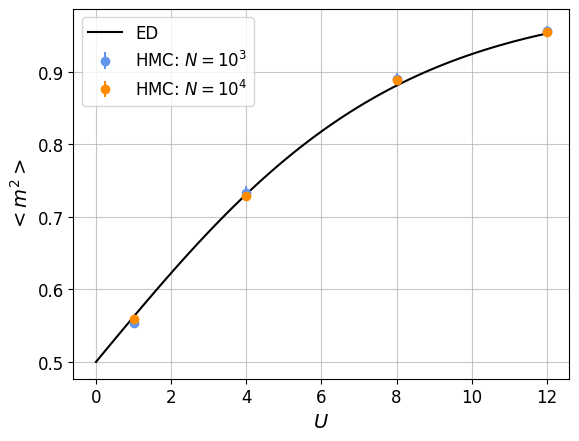

In [10]:
# Local moment data for different values of U using HMC
U_values = np.array([1,4,8,12])
m_sq = np.array([0.554,0.733,0.890,0.956])
m_sq_err = np.array([0.005,0.009,0.008,0.007])
m_sq_2 = np.array([0.559,0.729,0.888,0.954])
m_sq_err_2 = np.array([0.002,0.003,0.003,0.002])

# Plot the local moment for the HMC and ED methods
plt.errorbar(U_values, m_sq, yerr=m_sq_err, fmt="o", label=r'HMC: $N=10^3$', color = 'cornflowerblue')
plt.errorbar(U_values, m_sq_2, yerr=m_sq_err_2, fmt="o", label=r'HMC: $N=10^4$', color = 'darkorange')
plt.plot(U_arr, m_sq_arr, color='black', label='ED')
plt.xlabel(r'$U$', fontsize=14)
plt.ylabel(r'$<m^2>$', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
_ = plt.grid(True, alpha=0.7)
# plt.savefig("plots/m_sq.png", dpi=500)

----------------------------------------------

## Green's function

In [11]:
# Parameter definition
beta = 10  # Inverse temperature
U = 1  # Interaction strength
Nt = 24  # Number of time slices (Trotter decomposition)
delta_leapfrog = 0.06  # Step size for leapfrog integration in HMC
N_steps_leapfrog = 20  # Number of leapfrog steps per HMC iteration
N_thermal = 1000  # Number of thermalization steps before collecting samples
N_samples = 10**5  # Total number of HMC samples
Utilde = U * beta / Nt  # Rescaled interaction parameter

# Initialize the field phi with Gaussian-distributed values
phi_initial = np.random.normal(0, np.sqrt(Utilde), Nt)

# Run the HMC algorithm to generate phi samples
phi_samples, N_accept = hmc_run(phi_initial, N_samples, N_thermal, delta_leapfrog, N_steps_leapfrog, Nt, Utilde)

# Compute the acceptance rate of the HMC sampling process
acceptance_rate = N_accept / N_samples
print(f"Acceptance rate: {acceptance_rate:.2%}")

Acceptance rate: 81.38%


In [12]:
# Saving the samples in a Pandas DataFrame
# Uncomment this for saving

# filename = f'data_hmc/phi_beta{beta}_U{U}_samples{N_samples}.csv'
# df = pd.DataFrame({'Phi': phi_samples})
# df.to_csv(filename, index=False)

In [13]:
# Plot to have a look at the thermalization
# Uncomment this for a visulization of the first 3000 steps

# phi_sq = [np.mean(phi**2) for phi in phi_samples]
# plt.plot(phi_sq[:3000])
# plt.xlabel("Monte Carlo steps")
# _ = plt.ylabel(r"$⟨\phi^2⟩$")

In [ ]:
thinning = 368  # Interval for selecting samples (to reduce autocorrelation)
n_boot = 10**5  # Number of bootstrap resampling iterations

# Compute the Green's function using the sampled field configurations
G_up, G_up_avg, G_up_error, samples_green = compute_greens_function(phi_samples, N_thermal, thinning, Nt, n_boot)

# Print the result
print(f"G(tau = 0) = {G_up_avg[0]:.3f} ± {G_up_error[0]:.3f}")

G(tau = 0) = 0.476 ± 0.030


In [20]:
# Compute the autocorrelation time of G_up(tau=0)[phi]
# The first comutation should be done with a thinning = 1, to get the autocorrelation time
# Then adjust the 'thinning' parameter to thinning >= 4*tau

print(f"Autocorrelation time: {integrated_autocorrelation_time(G_up[:,0],until=int(samples_green), fast=True):.2f}")

Autocorrelation time: 0.78


In [21]:
# Plot to have a look at the normalized autocorrelation
# Uncomment this for a visulization of the first 10 steps

# # Compute the normalized autocorrelation of G_up(tau=0)[phi]
# acf = normalized_autocorrelation_function(G_up[:,0],until=int(samples_green), fast=True)

# # Plot
# plt.plot(acf[:10])
# plt.xlabel(r'$\Delta t$')
# _ = plt.ylabel(r'$\Gamma(\Delta t)$')

In [22]:
# Saving the Green's function in a Pandas DataFrame
# Uncomment this for saving

# filename = f'data_hmc/green_beta{beta}_U{U}_samples{N_samples}_thinning{thinning}.csv'
# df = pd.DataFrame({'Mean': G_up_avg, 'Error': G_up_error})
# df.to_csv(filename, index=False)

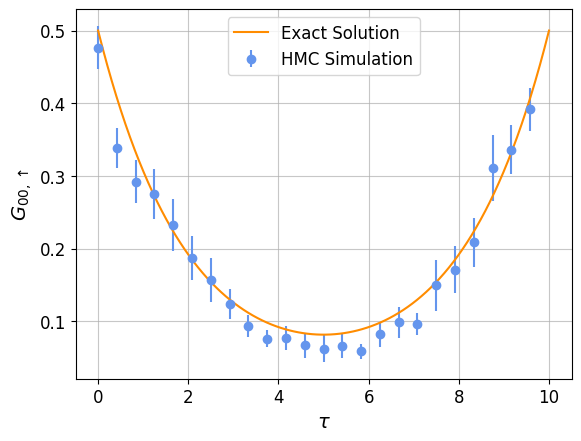

In [23]:
# Time axis for the Green's function computed with HMC
tau = np.arange(Nt) * beta / Nt

# Exact solution
tau_exact = np.linspace(0, beta, 100)
green_exact = G_exact(tau_exact, U, beta)

# Plot of the Green's function computed with HMC and the exact solution
plt.errorbar(tau, G_up_avg, yerr=G_up_error, fmt='o', color='cornflowerblue', label='HMC Simulation')
plt.plot(tau_exact, green_exact, color = 'darkorange', label='Exact Solution')
plt.xlabel(r'$\tau$', fontsize=14)
plt.ylabel(r'$G_{00,\uparrow}$', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.7)
_ = plt.legend(fontsize=12)

### Final Plot

In [24]:
# Load data for the Green's function for HMC runs with 10^5 and 10^6 numbers of samples
filename_1= f'data/green_beta10_U1_samples100000_thinning368.csv'
filename_2 = f'data/green_beta10_U1_samples1000000_thinning448.csv'
df_1 = pd.read_csv(filename_1)
df_2 = pd.read_csv(filename_2)

# Extract mean and error values for the Green's function
G_mean_1 = df_1["Mean"]
G_mean_2 = df_2["Mean"]
G_error_1 = df_1["Error"]
G_error_2 = df_2["Error"]

# Load data from the Exact Diagonalization method
data_ED = np.loadtxt('data/green_function_n0_j0_spin1_data_U1_beta10_sites1.txt', comments="#")

# Extrahiere tau (Spalte 0) und g_up (Spalte 1)
tau_ED = data_ED[:, 0]
green_ED = data_ED[:, 1]

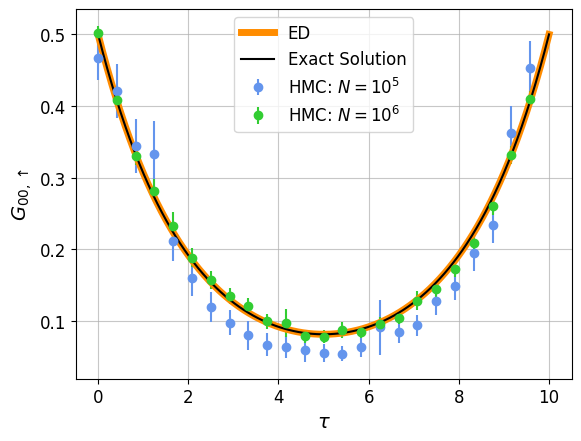

In [26]:
# Paramters
beta = 10
U = 1
Nt = 24

# Time axis for the Green's functions computed with HMC
tau = np.arange(Nt) * beta / Nt

# Exact solution
tau_exact = np.linspace(0, beta, 100)
green_exact = G_exact(tau_exact, U, beta)

# Plot the Green's function for the HMC and ED methods and for the exact solution
plt.errorbar(tau, G_mean_1, yerr=G_error_1, color='cornflowerblue', fmt='o', label=r'HMC: $N=10^5$')
plt.errorbar(tau, G_mean_2, yerr=G_error_2, color='limegreen', fmt='o', label=r'HMC: $N=10^6$')
plt.plot(tau_ED, green_ED, color='darkorange', linewidth=5, label='ED')
plt.plot(tau_exact, green_exact, color = "black", label='Exact Solution')
plt.xlabel(r'$\tau$', fontsize=14)
plt.ylabel(r'$G_{00,\uparrow}$', fontsize=14)
plt.grid(True, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
_ = plt.legend(fontsize=12)
# plt.savefig("plots/green.png", dpi=500)